# AstraDB ColBERT or Pinecone/Weaviate Hybrid Search?
Author: Tiernan Lindauer, Datastax Inc.

## Step 1: Setup

Install the required packages (`requirements.txt`)

In [114]:
# Some minor setup for the notebook
import warnings
import nest_asyncio

# Ignore all warnings
warnings.filterwarnings("ignore")

# Allows for running async code in Jupyter notebooks
nest_asyncio.apply()

In [9]:
import os
import time
import openai
import weaviate
from dotenv import load_dotenv
from langchain_community.retrievers import (
    WeaviateHybridSearchRetriever,
)
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

Load the corpus.

In [25]:
corpus_path = "dataset/movie_scripts/test"

In [24]:
def load_and_split_text(folder_path):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    texts = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            text = file.read()
            texts.extend(text_splitter.split_text(text))
    return texts


corpus = load_and_split_text(corpus_path)

In [56]:
# Specify the number of results for each search.
n_results = 5

Create Weaviate cluster (no authentication) -- **you need to create this, then come back**!

In [38]:
WEAVIATE_URL = input("Enter your weaviate cluster URL: ")

In [11]:
OPENAI_API_KEY = input("Enter your OpenAI API key: ")

In [39]:
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
openai.api_key = OPENAI_API_KEY
client = weaviate.Client(
    url=WEAVIATE_URL,
    additional_headers={
        "X-Openai-Api-Key": OPENAI_API_KEY,
    },
)
embeddings = OpenAIEmbeddings()

/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/weaviate/warnings.py:162: DeprecationWarning: Dep016: Python client v3 `weaviate.Client(...)` connections and methods are deprecated. Update
            your code to use Python client v4 `weaviate.WeaviateClient` connections and methods.

            For Python Client v4 usage, see: https://weaviate.io/developers/weaviate/client-libraries/python
            For code migration, see: https://weaviate.io/developers/weaviate/client-libraries/python/v3_v4_migration
            
  warnings.warn(


In [49]:
weaviate_retriever = WeaviateHybridSearchRetriever(
    client=client,
    index_name="LangChain",
    text_key="text",
    attributes=['index'],
    create_schema_if_missing=True,
    k=n_results,
)

In [41]:
# ONLY RUN ONCE!
docs = []
index_val = 0
for doc in corpus:
    docs.append(Document(
        metadata={
            "name": "montypython",
            "date": time.strftime("%m/%d/%Y"),
            "index": index_val,
        },
        page_content=doc
    ))
    index_val += 1
weaviate_retriever.add_documents(docs)
# Now let's load Pinecone

['158738c2-2b8e-47c7-9259-4d1b314e9f0e',
 'dd9ee7e6-4ee3-4172-8140-f3afc49873df',
 '24a4dcc6-0836-4352-b435-4e2cf8e26984',
 'f5b3042e-11e7-45ff-a184-be0310a94d15',
 '6cbd25fd-1a8d-4c18-a739-3a62d9aaa0ff',
 'e549ddb9-1ed2-43a2-93cc-c60b2eb46c4f',
 '9dc6fff7-2f07-48a1-b775-67f96f3762c3',
 '62022787-0f6a-4bf3-b350-9e4f05d8e750',
 'acc7fce5-02dc-4e84-bafa-a5cc69843c05',
 '2087742d-a086-4f9b-9bf6-7e19a9af608c',
 '6d915d06-c6f6-48ff-af62-7db2e321d450',
 '3424d0fc-3061-4236-a377-3ea0443f4656',
 '53e5be64-f093-4ee4-8ffd-1cbf342033b7',
 '98bc2518-a7e7-47cd-a2a1-9f8cc913be50',
 '51ba56a4-806b-4831-8138-a0c572eb14ab',
 '7d6d1681-dc78-48c0-b03d-7d120c69fedc',
 '93979da7-9bb0-4651-aa0d-69a5cdaf9664',
 'b794f92e-0775-4a2a-be58-1f1277a604e5',
 '186972cd-8426-41e2-9e28-6249894f3185',
 '16f1ef4c-5653-483f-b43a-f9cc202fcdc3',
 'e8b136e2-f7cf-45cb-ac92-bbcc5d90351d',
 '6b27b4fb-0de2-4ba9-ac7f-0712bfe563a3',
 '2a19c697-94bf-40be-9424-42b2acc6ee85',
 '827bbd18-7ae1-46eb-88d6-ddf53ee24eb7',
 '39d05831-9215-

In [17]:
import wget
import certifi
from pinecone_text.sparse import BM25Encoder

os.environ['SSL_CERT_FILE'] = certifi.where()

bm25_encoder = BM25Encoder().default()

In [18]:
bm25_encoder.fit(corpus)
current_directory = os.getcwd()
json_file_path = os.path.join(current_directory, "bm25_values.json")


  0%|          | 0/237 [00:00<?, ?it/s]

In [20]:
from pinecone import Pinecone, ServerlessSpec

index_name = "pinecone-hybrid-search-1"

pc_api_key = input("Enter your Pinecone API key: ")
# initialize Pinecone client
pc = Pinecone(api_key=pc_api_key)

# create the index
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=1536,  # dimensionality of dense model
        metric="dotproduct",  # sparse values supported only for dotproduct
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )

    metadatas = []
    for i in range(len(corpus)):
        metadatas.append({
            "name": "montypython",
            "date": time.strftime("%m/%d/%Y"),
            "index": i,
        })


In [22]:
index = pc.Index(index_name)

In [57]:
from langchain_community.retrievers import PineconeHybridSearchRetriever

pinecone_retriever = PineconeHybridSearchRetriever(
    embeddings=embeddings, sparse_encoder=bm25_encoder, index=index, top_k=n_results
)

In [27]:
pinecone_retriever.add_texts(corpus, metadatas=metadatas)

  0%|          | 0/8 [00:00<?, ?it/s]

Let's run an example query to compare the results of Weaviate/Pinecone to the perfect K-Nearest-Neighbors (KNN) search later.

In [28]:
question = "Who is the director of \"Monty Python and the Holy Grail\"?"

In [68]:
print("Weaviate results:")
weaviate_results = weaviate_retriever.invoke(question, score=True)
weaviate_indices = [result.metadata['index'] for result in weaviate_results]
print("    Metadata: ", weaviate_indices)
print("Pinecone results:")
pinecone_results = pinecone_retriever.invoke(question, score=True)
pinecone_indices = [int(result.metadata['index']) for result in pinecone_results]
print("    Metadata: ", pinecone_indices)

Weaviate results:
    Metadata:  [2, 16, 0, 1, 15]
Pinecone results:
    Metadata:  [0, 1, 2, 15, 16]


## Step 2: Process the Perfect K-Nearest-Neighbors (KNN) Search 

In [60]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
def embed_texts(texts):
    return embeddings.embed_documents(texts)


corpus_embeddings = embed_texts(corpus)

# Use KNN to find the closest 5 documents
knn = NearestNeighbors(n_neighbors=n_results, metric='cosine').fit(corpus_embeddings)

In [69]:
distances, knn_indices = knn.kneighbors([embeddings.embed_query(question)])
knn_indices = knn_indices[0]
print("KNN results:")
print("    Indices: ", knn_indices)

KNN results:
    Indices:  [ 2  0 16  1 15]


In [129]:
import numpy as np
from scipy.stats import kendalltau


def dcg(relevances, k):
    relevances = np.array(relevances)[:k]
    if relevances.size:
        return np.sum((2 ** relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    return 0.0


def ndcg(relevances, k):
    ideal_relevances = sorted(relevances, reverse=True)
    return dcg(relevances, k) / dcg(ideal_relevances, k) if dcg(ideal_relevances, k) > 0 else 0.0


def get_result_stats(retrieved_docs, ground_truth, k):
    precisions = []
    recalls = []
    f1_scores = []

    for retrieved, relevant in zip(retrieved_docs, ground_truth):
        # Ensure relevant is a list
        relevant = set(relevant)

        # Calculate true positives
        retrieved_set = set(retrieved[:k])
        true_positives = len(retrieved_set & relevant)

        # Calculate Precision
        precision = true_positives / len(retrieved_set) if len(retrieved_set) > 0 else 0
        precisions.append(precision)

        # Calculate Recall
        recall = true_positives / len(relevant) if len(relevant) > 0 else 0
        recalls.append(recall)

        # Calculate F1 Score
        if precision + recall > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
        else:
            f1_score = 0
        f1_scores.append(f1_score)

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)

    mrr = []
    ndcg_scores = []

    for retrieved, relevant in zip(retrieved_docs, ground_truth):
        # Create relevance scores
        relevances = [1 if doc in relevant else 0 for doc in retrieved]

        # Calculate MRR
        reciprocal_rank = 0
        for i, rel in enumerate(relevances):
            if rel == 1:
                reciprocal_rank = 1 / (i + 1)
                break
        mrr.append(reciprocal_rank)

        # Calculate nDCG
        ndcg_score = ndcg(relevances, k)
        ndcg_scores.append(ndcg_score)

    avg_mrr = np.mean(mrr)
    avg_ndcg = np.mean(ndcg_scores)

    return {
        'Precision': avg_precision,
        'Recall': avg_recall,
        'F1-Score': avg_f1,
        'MRR': avg_mrr,
        'nDCG': avg_ndcg,
    }

Evaluate the results of the example query above.

In [ ]:
print("Weaviate results:", get_result_stats([weaviate_indices], [knn_indices], n_results))
print("Pinecone results: ", get_result_stats([pinecone_indices], [knn_indices], n_results))

## Step 3: Setup ColBERT through AstraDB

In [106]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from ragstack_colbert import CassandraDatabase, ColbertEmbeddingModel, ColbertVectorStore, ColbertRetriever

In [102]:
astra_database_id = input("Enter your AstraDB database ID: ")

In [103]:
astra_token = input("Enter your AstraDB token: ")

In [104]:
keyspace = "benchmarking"
database = CassandraDatabase.from_astra(astra_token=astra_token, database_id=astra_database_id, keyspace=keyspace)
embedding_model = ColbertEmbeddingModel()
vector_store = ColbertVectorStore(database=database, embedding_model=embedding_model)

/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/cassandra/datastax/cloud/__init__.py:172: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  ssl_context = SSLContext(PROTOCOL_TLS)
/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[Jun 14, 14:40:25] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [105]:
def store_in_astra(chunks):
    metadatas = []
    for i in range(len(chunks)):
        metadatas.append({"name": "montypython", "date": time.strftime("%m/%d/%Y"), 'index': i})
    vector_store.add_texts(chunks, metadatas=metadatas)


store_in_astra(corpus)

/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [109]:
colbert_retriever = ColbertRetriever(embedding_model=embedding_model, database=database)

In [123]:
def get_astra_results(query, k=5):
    results = colbert_retriever.text_search(query, k=k)
    return results

In [115]:
print("ColBERT results:")
print(get_astra_results(question, k=n_results))

ColBERT results:

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . Who is the director of "Monty Python and the Holy Grail"?, 		 True, 		 None
#> Output IDs: torch.Size([18]), tensor([  101,     1,  2040,  2003,  1996,  2472,  1997,  1000, 18446, 18750,
         1998,  1996,  4151, 24665, 12502,  1000,  1029,   102])
#> Output Mask: torch.Size([18]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

[15, 2, 0, 3, 16]


In [121]:
from tqdm import tqdm
from time import time

In [124]:
all_knn_indices = []
all_weaviate_indices = []
all_pinecone_indices = []
all_colbert_indices = []

weaviate_latencies = []
pinecone_latencies = []
colbert_latencies = []

with open('dataset/queries/holy_grail_result.txt', 'r') as f:
    for line in tqdm(f.readlines()):
        line = line.strip()

        start = time()
        weaviate_results = weaviate_retriever.invoke(line)
        end = time()
        weaviate_latencies.append(end - start)
        weaviate_indices = [result.metadata['index'] for result in weaviate_results]
        all_weaviate_indices.append(weaviate_indices)

        start = time()
        pinecone_results = pinecone_retriever.invoke(line)
        end = time()
        pinecone_latencies.append(end - start)
        pinecone_indices = [int(result.metadata['index']) for result in pinecone_results]
        all_pinecone_indices.append(pinecone_indices)

        start = time()
        colbert_results = get_astra_results(line)
        end = time()
        colbert_indices = [int(float(result[0].metadata['index'])) for result in colbert_results]
        colbert_latencies.append(end - start)
        all_colbert_indices.append(colbert_indices)

        distances, knn_indices = knn.kneighbors([embeddings.embed_query(question)])
        knn_indices = knn_indices[0]

        all_knn_indices.append(knn_indices)

100%|██████████| 100/100 [03:47<00:00,  2.27s/it]


In [131]:
weaviate_stats = get_result_stats(all_weaviate_indices, all_knn_indices, n_results)
pinecone_stats = get_result_stats(all_pinecone_indices, all_knn_indices, n_results)
colbert_stats = get_result_stats(all_colbert_indices, all_knn_indices, n_results)

In [145]:
from rich.text import Text
import rich
from rich.console import Console

console = Console()

# Print a table of the results (Weaviate, Pinecone, ColBERT vs the different stats)
table = rich.table.Table(title="Retrieval Results", show_edge=False)
table.add_column("Metric", style="cyan")
table.add_column("Weaviate", style="magenta")
table.add_column("Pinecone", style="green")
table.add_column("AstraDB + ColBERT", style="blue")

def format_cell(value, is_max=True):
    text = Text(str(value))
    if is_max:
        text.stylize("bold underline")
    return text

# Add stats to table with formatting
for metric in weaviate_stats:
    values = [
        weaviate_stats[metric],
        pinecone_stats[metric],
        colbert_stats[metric]
    ]
    max_value = max(values)
    formatted_values = [
        format_cell(value, is_max=(value == max_value)) for value in values
    ]
    table.add_row(metric, *formatted_values)

# Calculate average latencies and add them to the table
avg_weaviate_latency = sum(weaviate_latencies) / len(weaviate_latencies)
avg_pinecone_latency = sum(pinecone_latencies) / len(pinecone_latencies)
avg_colbert_latency = sum(colbert_latencies) / len(colbert_latencies)

latencies = [avg_weaviate_latency, avg_pinecone_latency, avg_colbert_latency]
min_latency = min(latencies)
formatted_latencies = [
    format_cell(latency, is_max=(latency == min_latency)) for latency in latencies
]

table.add_row("Average Latency", *formatted_latencies)

# Print the table
console.print(table)

                                  Retrieval Results                                  
 Metric          ┃ Weaviate             ┃ Pinecone            ┃ AstraDB + ColBERT    
━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━
 Precision       │ 0.018000000000000002 │ 0.042               │ 0.018                
 Recall          │ 0.018000000000000002 │ 0.042               │ 0.018                
 F1-Score        │ 0.018000000000000006 │ 0.04200000000000001 │ 0.018000000000000002 
 MRR             │ 0.065                │ 0.0915              │ 0.041833333333333333 
 nDCG            │ 0.07154648767857288  │ 0.12105456186979165 │ 0.053530944869199334 
 Average Latency │ 0.507214252948761    │ 0.2146481132507324  │ 1.4207204461097718   

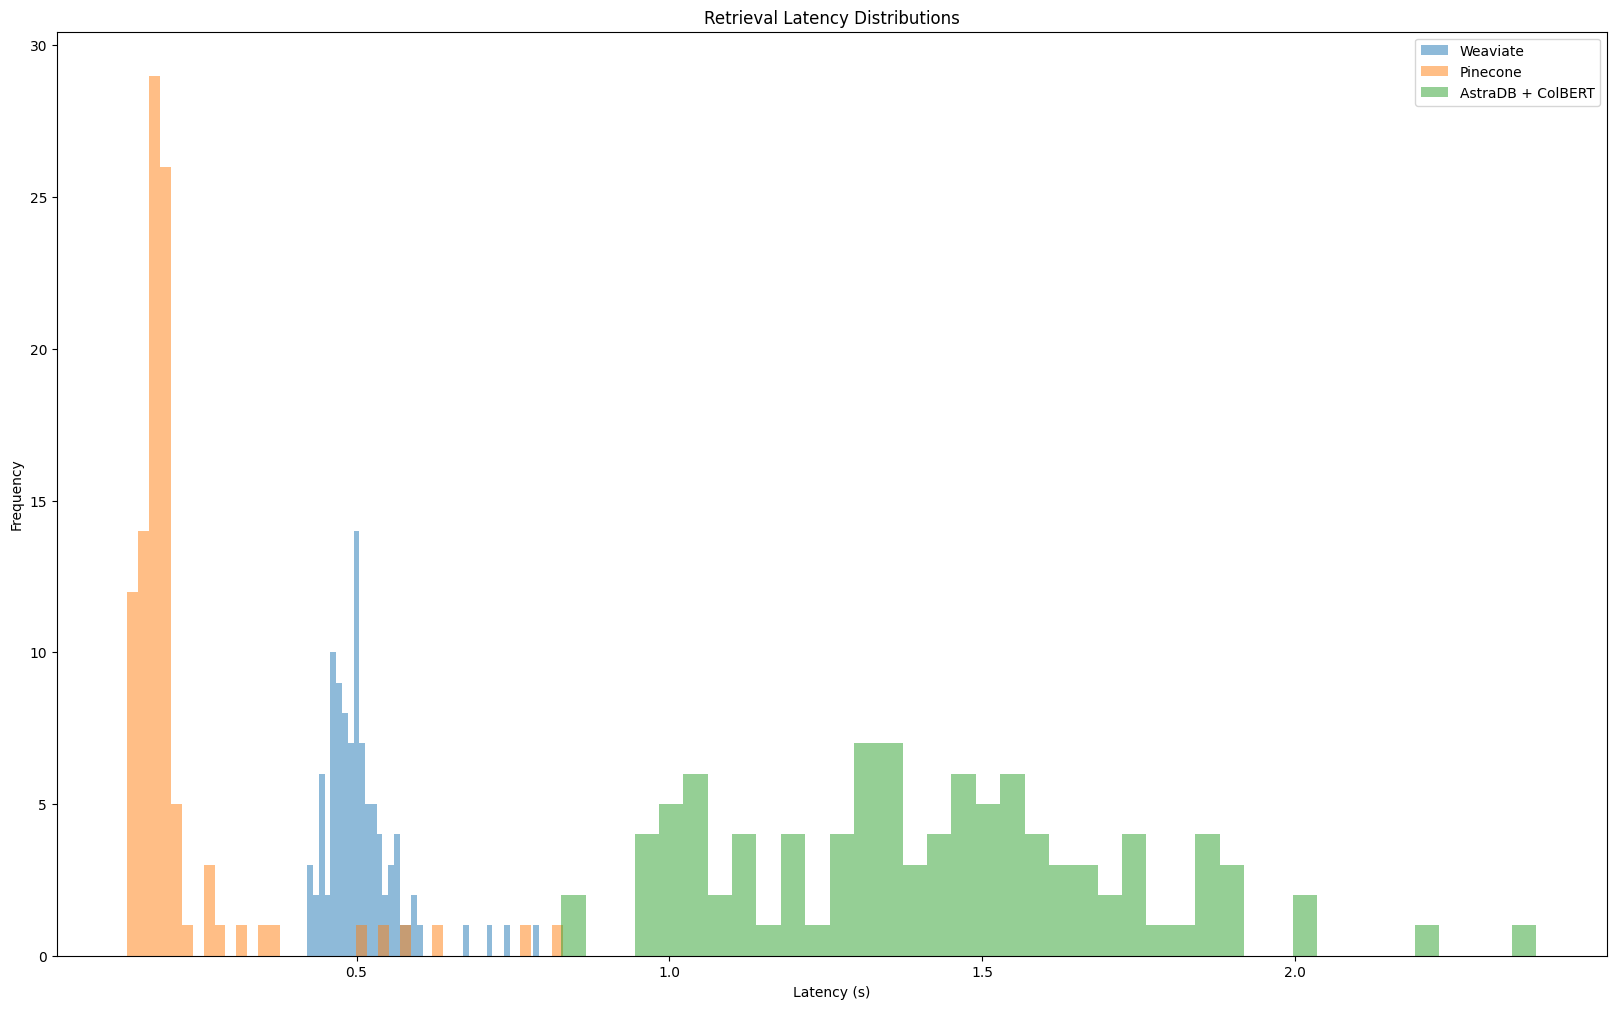

In [146]:
# Plot latency distributions
import matplotlib.pyplot as plt

bins = 40
plt.hist(weaviate_latencies, bins=bins, alpha=0.5, label='Weaviate')
plt.hist(pinecone_latencies, bins=bins, alpha=0.5, label='Pinecone')
plt.hist(colbert_latencies, bins=bins, alpha=0.5, label='AstraDB + ColBERT')

plt.legend(loc='upper right')
plt.xlabel('Latency (s)')
plt.ylabel('Frequency')
plt.title('Retrieval Latency Distributions')

# set the size bigger
plt.rcParams["figure.figsize"] = (20, 12)